In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep="\t", header=None, names=["label", "text"])

df['label'] = df['label'].map({'ham':0, 'spam':1})
df['text'] = df['text'].str.lower().str.replace('[^a-z0-9 ]','',regex=True)
df['text'] = df['text'].apply(lambda x: " ".join([w for w in x.split() if w not in ENGLISH_STOP_WORDS]))

vec = TfidfVectorizer()
X = vec.fit_transform(df['text'])
y = df['label'].values

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_tr, y_tr)

print("Stump Train:", accuracy_score(y_tr, stump.predict(X_tr)))
print("Stump Test:", accuracy_score(y_ts, stump.predict(X_ts)))
print(confusion_matrix(y_ts, stump.predict(X_ts)))


Stump Train: 0.8891631142023783
Stump Test: 0.8896860986547085
[[965   1]
 [122  27]]


In [20]:
results = []

for n in [5, 10, 25, 50, 100]:
    for lr in [0.1, 0.5, 1.0]:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr
        )
        model.fit(X_tr, y_tr)
        acc = accuracy_score(y_ts, model.predict(X_ts))
        results.append((n, lr, acc))

res_df = pd.DataFrame(results, columns=["n_estimators","learning_rate","test_acc"])
print(res_df)

best = res_df.sort_values("test_acc", ascending=False).iloc[0]
print("\nBest Params:", best)




    n_estimators  learning_rate  test_acc
0              5            0.1  0.947368
1              5            0.5  0.938596
2              5            1.0  0.929825
3             10            0.1  0.938596
4             10            0.5  0.964912
5             10            1.0  0.964912
6             25            0.1  0.947368
7             25            0.5  0.964912
8             25            1.0  0.947368
9             50            0.1  0.956140
10            50            0.5  0.956140
11            50            1.0  0.956140
12           100            0.1  0.956140
13           100            0.5  0.956140
14           100            1.0  0.956140

Best Params: n_estimators     10.000000
learning_rate     0.500000
test_acc          0.964912
Name: 4, dtype: float64


In [21]:
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=int(best["n_estimators"]),
    learning_rate=float(best["learning_rate"])
)

best_model.fit(X_tr, y_tr)

print("Train Accuracy:", accuracy_score(y_tr, best_model.predict(X_tr)))
print("Test Accuracy:", accuracy_score(y_ts, best_model.predict(X_ts)))
print(confusion_matrix(y_ts, best_model.predict(X_ts)))


Train Accuracy: 0.9846153846153847
Test Accuracy: 0.9649122807017544
[[39  3]
 [ 1 71]]


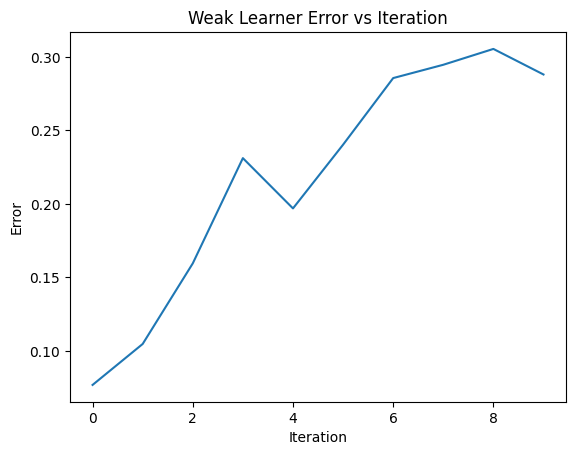

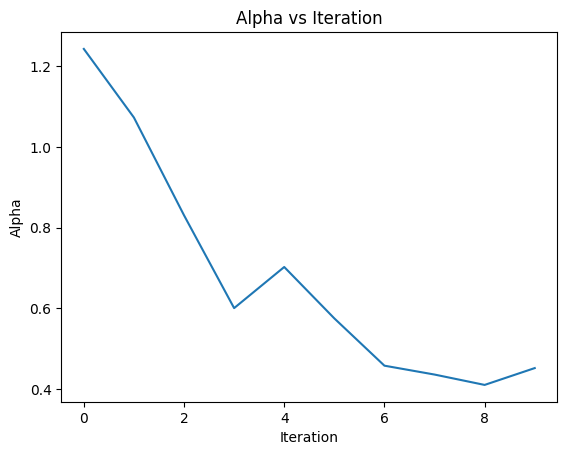

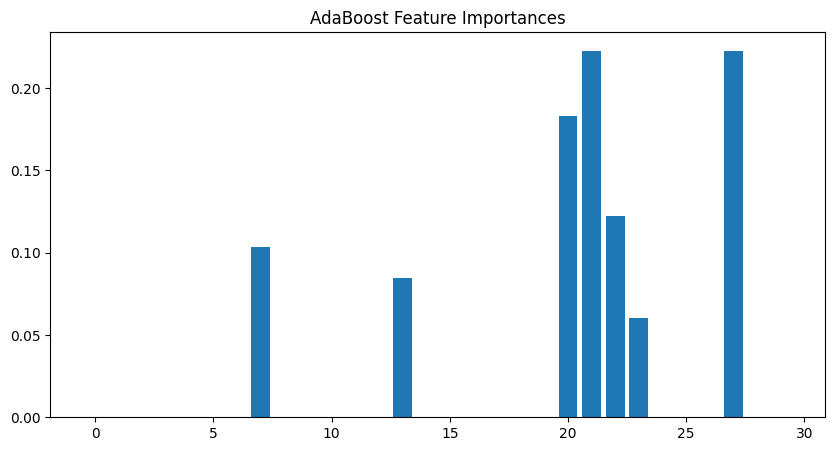

In [22]:
errors = best_model.estimator_errors_
weights = best_model.estimator_weights_

plt.plot(errors)
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(weights)
plt.title("Alpha vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()

importances = best_model.feature_importances_

plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances)
plt.title("AdaBoost Feature Importances")
plt.show()


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import re

from google.colab import files
uploaded = files.upload()
WISDM_PATH = next(iter(uploaded)) if uploaded else 'WISDM_ar_v1.1_raw.txt'
cols=['user_id','activity','timestamp','x','y','z']
wisdm_rows=[]
with open(WISDM_PATH,'r') as f:
    for line in f:
        line=line.strip()
        if not line: continue
        line=line.rstrip(',')
        parts = re.split('[,\\s]+', line)
        if len(parts) < 6: continue
        try:
            user=int(parts[0]); activity=parts[1]; timestamp=int(parts[2])
            x=float(parts[3]); y=float(parts[4]); z=float(parts[5])
            wisdm_rows.append([user, activity, timestamp, x, y, z])
        except:
            continue
df_wisdm = pd.DataFrame(wisdm_rows, columns=cols)
df_wisdm['activity_clean'] = df_wisdm['activity'].str.replace('[^A-Za-z]','',regex=True).str.lower()
def label_activity(a):
    if a in ['jogging','upstairs','up']: return 1
    if a in ['walking','walk','sitting','standing','downstairs','down']: return 0
    return 0
df_wisdm['label'] = df_wisdm['activity_clean'].apply(label_activity)
df_wisdm = df_wisdm.dropna().reset_index(drop=True)
df_wisdm['sample_idx'] = df_wisdm.groupby(['user_id','activity_clean']).cumcount()
window_size = 100
df_wisdm['window_id'] = (df_wisdm['sample_idx'] // window_size)
grouped = df_wisdm.groupby(['user_id','activity_clean','window_id','label'])
feats = grouped.agg({'x':['mean','std','min','max'],'y':['mean','std','min','max'],'z':['mean','std','min','max']})
feats.columns = ['_'.join(col).strip() for col in feats.columns.values]
feats = feats.reset_index()
print("Aggregated windows:", feats.shape)

Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw (2).txt
Aggregated windows: (119, 16)


In [36]:
def manual_adaboost(X, y, T=50, base_estimator=DecisionTreeClassifier(max_depth=1), verbose=False):
    n_samples, n_features = X.shape
    D = np.ones(n_samples) / n_samples
    learners = []
    alphas = []
    errors = []

    for t in range(T):
        learner = base_estimator.fit(X, y, sample_weight=D)
        y_pred = learner.predict(X)

        incorrect = (y_pred != y)
        error_t = np.sum(D[incorrect])

        if error_t == 0 or error_t >= 0.5:
            if verbose:
                print(f"Iteration {t+1}: Error {error_t}, stopping AdaBoost.")
            break

        alpha_t = 0.5 * np.log((1 - error_t) / error_t)

        D = D * np.exp(-alpha_t * y * y_pred)
        D = D / np.sum(D)

        learners.append(learner)
        alphas.append(alpha_t)
        errors.append(error_t)

        if verbose:
            print(f"Iteration {t+1}: Error = {error_t:.4f}, Alpha = {alpha_t:.4f}")

    return learners, alphas, errors

def ensemble_predict(learners, alphas, X):
    if not learners or not alphas:
        return np.zeros(X.shape[0])

    predictions = np.array([learner.predict(X) for learner in learners])

    weighted_predictions = np.array([a * p for a, p in zip(alphas, predictions)])

    return np.sign(np.sum(weighted_predictions, axis=0))

Iteration 1: Error 0.0, stopping AdaBoost.
Train (manual AdaBoost) Accuracy: 0.5181
Train (manual AdaBoost) Confusion Matrix:
[[43  0]
 [40  0]]

Test (manual AdaBoost) Accuracy: 0.5000
Test (manual AdaBoost) Confusion Matrix:
[[18  0]
 [18  0]]



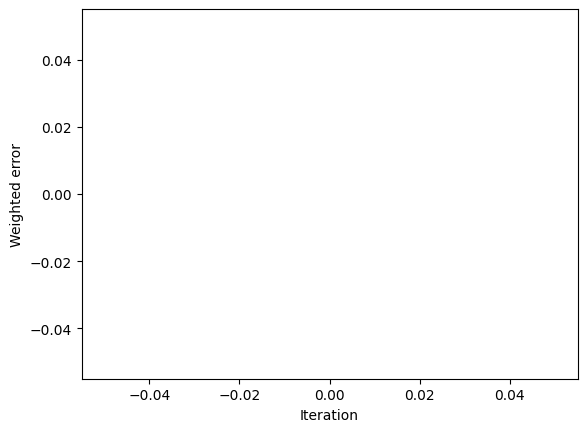

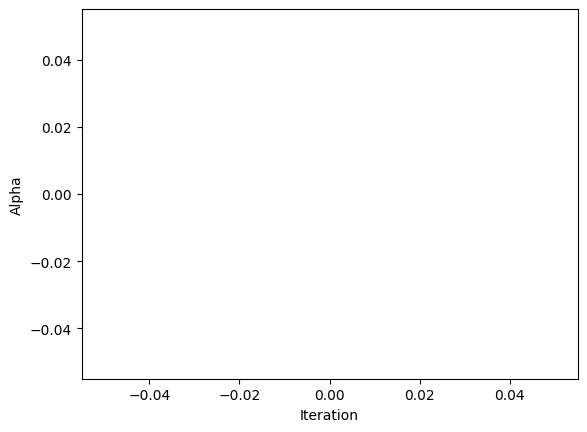

In [37]:
yw_train_transformed = yw_train.values.copy()
yw_train_transformed[yw_train_transformed == 0] = -1

yw_test_transformed = yw_test.values.copy()
yw_test_transformed[yw_test_transformed == 0] = -1

learners_w, alphas_w, errors_w = manual_adaboost(Xw_train.values, yw_train_transformed, T=20, verbose=True)

yw_train_ens_raw = ensemble_predict(learners_w, alphas_w, Xw_train.values)
yw_test_ens_raw = ensemble_predict(learners_w, alphas_w, Xw_test.values)

yw_train_ens = (yw_train_ens_raw + 1) / 2
yw_test_ens = (yw_test_ens_raw + 1) / 2

yw_train_ens = yw_train_ens.astype(int)
yw_test_ens = yw_test_ens.astype(int)

print_metrics(yw_train, yw_train_ens, "Train (manual AdaBoost)")
print_metrics(yw_test, yw_test_ens, "Test (manual AdaBoost)")
plt.plot(range(1,len(errors_w)+1), errors_w, marker='o'); plt.xlabel('Iteration'); plt.ylabel('Weighted error'); plt.show()
plt.plot(range(1,len(alphas_w)+1), alphas_w, marker='o'); plt.xlabel('Iteration'); plt.ylabel('Alpha'); plt.show()

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

def print_metrics(y_true, y_pred, label):
    print(f"{label} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{label} Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}\n")

In [38]:
try:
    sk_w = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.0, random_state=42)
    sk_w.fit(Xw_train, yw_train)
except:
    sk_w = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.0, random_state=42)
    sk_w.fit(Xw_train, yw_train)
print_metrics(yw_train, sk_w.predict(Xw_train), "Train (sklearn AdaBoost)")
print_metrics(yw_test, sk_w.predict(Xw_test), "Test (sklearn AdaBoost)")

Train (sklearn AdaBoost) Accuracy: 1.0000
Train (sklearn AdaBoost) Confusion Matrix:
[[43  0]
 [ 0 40]]

Test (sklearn AdaBoost) Accuracy: 1.0000
Test (sklearn AdaBoost) Confusion Matrix:
[[18  0]
 [ 0 18]]

